In [206]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from batman import TransitModel
from astropy.io import fits
import astropy.units as u
from astropy.time import Time

from linea import CheopsLightCurve, params_55Cnce

p = params_55Cnce()

In [272]:
def simulate_roll_angle(phase, time): 
    # Compute rough approximation to a varying parallactic angle
    H = 2 * np.pi * (phase - 1.5)
    q = np.arctan2(np.sin(H) + 0.3 * (time - time[0]),
                   (np.tan(np.radians(0)) *
                    np.cos(np.radians(20)) -
                    np.sin(np.radians(20))*np.cos(H)))
    return np.degrees(q)

In [282]:
np.random.seed(42)
cheops_orbit_min = 99.5  # minutes

all_times = np.linspace(p.t0 - 0.5, p.t0 + 1., 2500)
cheops_phase = (((all_times[0] - all_times) * u.day) % 
                (cheops_orbit_min * u.min) / 
                (cheops_orbit_min * u.min)
               ).to(u.dimensionless_unscaled).value

bjd_time = all_times[cheops_phase > 0.5]
utc_time = Time(bjd_time, format='jd').isot
mjd_time = Time(bjd_time, format='jd').mjd

n_points = len(bjd_time)

conta_lc = 10 * np.ones(n_points) + np.random.randn(n_points)
conta_lc_err = np.ones(n_points) / 100
status = np.zeros(n_points)
event = np.zeros(n_points)
dark = 10 + np.random.randn(n_points)
background = 100 + np.random.randn(n_points)
roll_angle = simulate_roll_angle(cheops_phase[cheops_phase > 0.5], bjd_time)
location_x = 512 * np.ones(n_points)
location_y = 512 * np.ones(n_points)
centroid_x = location_x[0] + 0.2 * np.random.randn(n_points)
centroid_y = location_y[0] + 0.2 * np.random.randn(n_points)

sinusoid amp: 174.85 ppm


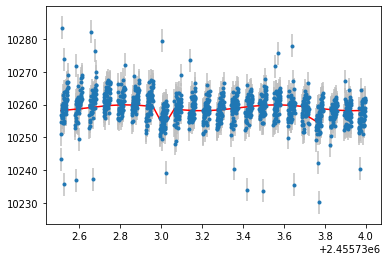

In [283]:
model = TransitModel(p, bjd_time, 
                     supersample_factor=3, 
                     exp_time=bjd_time[1] - bjd_time[0]
                     ).light_curve(p)
planet_phase = ((bjd_time - p.t0) % p.per) / p.per

sinusoid_amp = p.rp**2 / 4
print(f'sinusoid amp: {2e6 * sinusoid_amp:.2f} ppm')

model += sinusoid_amp * np.sin(2 * np.pi * (planet_phase + 0.5))

flux = (
    -2 * (bjd_time - bjd_time.mean()) + 
    2 * background + 
    1.1 * conta_lc + 
    dark + 
    25 * roll_angle / 360 + 
    2 * (centroid_x - location_x)**2 + 
    3 * (centroid_y - location_y)**2 +
    0.5 * (centroid_x - location_x) +
    0.1 * (centroid_y - location_y) + 
    1e3 * dark.mean()
) * model

fluxerr = np.std(flux) * np.ones(len(bjd_time))

n_outliers = 50

flux[np.random.randint(0, flux.shape[0], size=n_outliers)] += 3.5 * flux.std() * np.random.randn(n_outliers)

plt.errorbar(bjd_time, flux, fluxerr, fmt='.', ecolor='silver')
plt.plot(bjd_time, model * flux.mean(), 'r')

In [284]:
formatter = [
    ('UTC_TIME', '|S26', utc_time),
    ('MJD_TIME', '>f8', mjd_time),
    ('BJD_TIME', '>f8', bjd_time),
    ('FLUX', '>f8', flux),
    ('FLUXERR', '>f8', fluxerr),
    ('STATUS', '>i4', status),
    ('EVENT', '>i4', event),
    ('DARK', '>f8', dark),
    ('BACKGROUND', '>f8', background),
    ('CONTA_LC', '>f8', conta_lc),
    ('CONTA_LC_ERR', '>f8', conta_lc_err),
    ('ROLL_ANGLE', '>f8', roll_angle),
    ('LOCATION_X', '>f4', location_x),
    ('LOCATION_Y', '>f4', location_y),
    ('CENTROID_X', '>f4', centroid_x),
    ('CENTROID_Y', '>f4', centroid_y)
]

ra = np.recarray((n_points, ), 
                 names=[name for name, _, _ in formatter], 
                 formats=[fmt for _, fmt, _ in formatter])

for name, fmt, arr in formatter: 
    ra[name] = arr

In [285]:
fits.writeto('linea/data/example.fits', ra, overwrite=True)